In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, confusion_matrix, accuracy_score, recall_score
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder
import datetime
import os
import csv
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [2]:
# Parámetros
inputFolder = "1-input"
processFolder = "2-process"
outputFolder = "3-output"
logsFolder = "4-logs"

otherOutputFolder = "../5-evaluation/1-input/algorithms/"

dataVisualizationTopLimit = 20

testSize = 0.20
randomState = 0
samplingStrategy = 0.2
percentileNumberStd = 90
percentileNumberCorrelation = 90
partitionsNumber = int(1/testSize) #Para el kfold, es 1 sobre el test size (para que hagan match)

In [3]:
classifiers = {
  "K vecinos más cercanos": { "name": "K vecinos más cercanos", "acronym": "KNN", "classifier": KNeighborsClassifier(n_neighbors=1, n_jobs=-1) }, 
  "Máquina de vectores de soporte": { "name": "Máquina de vectores de soporte", "acronym": "SVM", "classifier": SVC(random_state=randomState, kernel='poly') }, 
  "Regresión logística": { "name": "Regresión logística", "acronym": "LR", "classifier": LogisticRegression(random_state=randomState, max_iter=200) }, 
  "Naive bayes gaussiano": { "name": "Naive bayes gaussiano", "acronym": "GNB", "classifier": GaussianNB() }, 
  "Aumento de gradiente": { "name": "Aumento de gradiente", "acronym": "GBM", "classifier": GradientBoostingClassifier(random_state=randomState) }, 
  "Árbol de decisión": { "name": "Árbol de decisión", "acronym": "DT", "classifier": DecisionTreeClassifier(random_state=randomState) }, 
  "Bosque aleatorio": { "name": "Bosque aleatorio", "acronym": "RF", "classifier": RandomForestClassifier(random_state=randomState) }, 
}

In [4]:
# Funciones utilitarias de archivos
def readCsvAsDict(filePath, delimiter=",", encoding="utf-8", header=0, dtype={}):
  df = pd.read_csv(filePath, delimiter=delimiter,encoding=encoding, header=header, dtype=dtype)
  df = df.replace(np.nan, '', regex=True)
  data = df.to_dict('records')
  return data

def readCsvAsDf(filePath, delimiter=",", encoding="utf-8", header=0, dtype={}):
  df = pd.read_csv(filePath, delimiter=delimiter,encoding=encoding, header=header, dtype=dtype)
  df = df.replace(np.nan, '', regex=True)
  return df

def writeDictToCsv(data, pathCsv, encoding='utf-8'):
  with open(pathCsv, 'w', newline='', encoding=encoding) as f:
    if data:
      writer = csv.DictWriter(f, fieldnames=data[0].keys(), lineterminator='\n')
      writer.writeheader()
      writer.writerows(data)
    else:
      f.write("")

def writeDfToCsv(data, pathCsv, encoding='utf-8'):
  data.to_csv(path_or_buf = pathCsv, encoding = encoding, index=False)

In [5]:
def showOversampling(df):
  colors = ["tab:blue", "tab:green"]
  topDf = df["contratado"].astype(str).value_counts().head(dataVisualizationTopLimit)
  print(topDf)
  classes = list(topDf.index)
  values = list(topDf.values)
  graph = plt.bar(classes, values, color=colors)

  percentage = []
  for value in values:
    pct = (value / sum(values)) * 100
    percentage.append(round(pct,2))

  for index, p in enumerate(graph):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2, y+height+50, str(percentage[index])+'%', ha='center', weight='bold')

  plt.xlabel("Contratado")
  plt.ylabel("Número de postulantes")
  plt.title("Número de postulantes contratados y no contratados")
  plt.show()

def showDifferentValues(df):
  categoricalColumns = [columnName for columnName, columnType in df.dtypes.to_dict().items() if columnName not in [ "contratado" ] and columnType == "object" ]
  categoricalCardinalColumns = [columnName for columnName in categoricalColumns if columnName not in [ "estadoUltimoEstudio", "gradoUltimoEstudio" ]]

  seriesDf = df.nunique().filter(items=categoricalCardinalColumns)
  resultDf = pd.DataFrame({'column': seriesDf.index, 'differentValuesNumber': seriesDf.values})
  resultDf.index = range(1,len(resultDf)+1)
  
  display(resultDf)

def showMaxMinNumerical(df):
  numericalColumns = [columnName for columnName, columnType in df.dtypes.to_dict().items() if columnName not in [ "contratado" ] and columnType == "float64" ]

  minSeriesDf = df.min().filter(items=numericalColumns)
  maxSeriesDf = df.max().filter(items=numericalColumns)
  resultDf = pd.DataFrame({'column': numericalColumns, 'minValue': minSeriesDf.values, 'maxValue': maxSeriesDf.values})
  resultDf.index = range(1,len(resultDf)+1)

  display(resultDf)
  
def showMetricsCharts(algorithmsMetricsList):
  metrics = [
    {"exactitud": "Exactitud"},
    {"precision": "Precisión"},
    {"sensibilidad": "Sensibilidad"},
    {"robustez": "Robustez"},
    {"tiempoPromedio": "Tiempo promedio"},
    {"promedioMetricas": "Promedio de métricas"},
  ]

  for metric in metrics:
    key = list(metric.keys())[0]
    value = metric[key]

    if key != "tiempoPromedio":
      data = {}
      for elem in algorithmsMetricsList:
        data["\n".join(elem["algoritmo"].split(" "))] = float(elem[key].strip('%')) / 100
      
      keys = list(data.keys())
      values = list(data.values())
        
      fig = plt.figure(figsize = (10, 5))
      
      sortedValues = sorted(values)
      maxValue, secondMaxValue, thirdMaxValue = sortedValues[len(sortedValues)-1], sortedValues[len(sortedValues)-2], sortedValues[len(sortedValues)-3]
      colors = ['tab:red' if (elem == maxValue) else ('tab:blue' if elem == secondMaxValue else ('tab:blue' if elem == thirdMaxValue else 'tab:blue')) for elem in values]
      plt.bar(keys, values, width = 0.4, color=colors)
      
      plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
      plt.ylabel("Porcentaje")
      plt.title("{} por modelo".format(value))
      plt.show()
    else:
      data = {}
      for elem in algorithmsMetricsList:
        data["\n".join(elem["algoritmo"].split(" "))] = float(elem[key].strip('s'))
      
      keys = list(data.keys())
      values = list(data.values())
        
      fig = plt.figure(figsize = (10, 5))
          
      sortedValues = sorted(values, reverse=True)
      maxValue, secondMaxValue, thirdMaxValue = sortedValues[len(sortedValues)-1], sortedValues[len(sortedValues)-2], sortedValues[len(sortedValues)-3]
      colors = ['tab:red' if (elem == maxValue) else ('tab:blue' if elem == secondMaxValue else ('tab:blue' if elem == thirdMaxValue else 'tab:blue')) for elem in values]
      plt.bar(keys, values, width = 0.4, color=colors)
      
      plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, y: "{:.5f}".format(x) + "s"))
      plt.ylabel("Segundos")
      plt.title("{} por modelo".format(value))
      plt.show()

In [6]:
def preprocessingData(inputPath):
  # Leyendo datos
  df = readCsvAsDf(inputPath)

  showOversampling(df)

  # Balanceo de datos: Sobremuestreo aleatorio (oversampling) (1 de cada 5)
  objectiveColumn = "contratado"
  dictResults = dict(df[objectiveColumn].value_counts().sort_index())

  maxKey = max(dictResults, key=dictResults.get)
  maxValue = max(dictResults.values())

  dfClassMaxKey = df[df[objectiveColumn] == maxKey]

  for key in dictResults.keys():
    if key != maxKey:
      dfClass = df[df[objectiveColumn] == key]
      dfClassSampled = dfClass.sample(int(maxValue * samplingStrategy), random_state=randomState, replace=True)
      dfClassMaxKey = pd.concat([dfClassMaxKey, dfClassSampled],axis=0)

  df = dfClassMaxKey

  showOversampling(df)

  # Aleatorizacion del orden de los registros para evitar sesgos(filas)
  df = df.sample(frac = 1, random_state=randomState).reset_index(drop=True)

  # Aplicando OrdinalEncoding a las variables categóricas ordinales()
  encoder = OrdinalEncoder(categories=[[ "Abandonado", "En Curso", "Graduado" ]])
  encoder.fit(df[["estadoUltimoEstudio"]])
  df["estadoUltimoEstudio"] = encoder.transform(df[["estadoUltimoEstudio"]])
  encoder = OrdinalEncoder(categories=[[ "Otro", "Secundario", "Terciario/Tecnico", "Universitario", "Posgrado", "Master", "Doctorado" ]])
  encoder.fit(df[["gradoUltimoEstudio"]])
  df["gradoUltimoEstudio"] = encoder.transform(df[["gradoUltimoEstudio"]])

  showDifferentValues(df)
  
  # Aplicando OneHotEncoding a las variables categóricas cardinales (transformación a numéricas mediante columnas)
  categoricalColumns = [columnName for columnName, columnType in df.dtypes.to_dict().items() if columnName not in [ "contratado" ] and columnType == "object" ]
  categoricalCardinalColumns = [columnName for columnName in categoricalColumns if columnName not in [ "estadoUltimoEstudio", "gradoUltimoEstudio" ]]

  for column in categoricalCardinalColumns:
    dummies = pd.get_dummies(df[[column]], prefix=column) # El dummy_na te genera una columna, asi tenga na's o no
    df = pd.concat([df, dummies], axis = 1)
    df = df.drop(columns=[column])

  showMaxMinNumerical(df)

  # Aplicando MinMaxScaler a las variables numéricas (normalización) (esto tambien incluye a lastEducationStatus y lastEducationDegree, ya numéricas)
  # Algunas quedaran en 0.9999, esto porque no todas manejan la misma escala (sin decimales, o solo un decimal)
  numericalColumns = [columnName for columnName, columnType in df.dtypes.to_dict().items() if columnName not in [ "contratado" ] and columnType == "float64" ]

  for column in numericalColumns:
    df[column] = df[column].fillna(0.0)
  mms = MinMaxScaler()
  df[numericalColumns] = mms.fit_transform(df[numericalColumns])

  print(len(df.columns))

  # Eliminando columnas con varianza cercana a cero, dejando el 10% de columnas con mayor varianza (variables no afectan en el resultado del modelo)
  df.loc['std'] = df.std()
  stdArray = df.iloc[len(df)-1]
  nthPercentileStd = np.percentile(stdArray, percentileNumberStd)
  print(nthPercentileStd)
  df = df.transpose()
  df = df[df["std"]>nthPercentileStd]
  df = df.transpose()
  df = df.drop(['std'], axis=0)

  print(len(df.columns))

  # Eliminando columnas con correlación cercana a uno, dejando el 90% de columnas con menor correlación
  correlationMatrix = df.corr().abs()
  correlationMatrix[correlationMatrix == 1.0] = 0.0
  maxCorrelationValues = [max(correlationMatrix[column]) for column in correlationMatrix.columns]
  nthPercentileCorrelation = np.percentile(maxCorrelationValues, percentileNumberCorrelation)
  print(nthPercentileCorrelation)
  highCorrelationColumns = [column for column in correlationMatrix.columns if max(correlationMatrix[column]) > nthPercentileCorrelation]
  df = df.drop(highCorrelationColumns, axis=1)

  print(len(df.columns))

  writeDfToCsv(df, os.path.join(processFolder, 'result.csv'))

  return df

In [7]:
def splitData(X, y):
  # Dividiendo los dataframes de entrenamiento y prueba
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testSize, random_state=randomState)

  return X_train, X_test, y_train, y_test

In [8]:
def trainModel(X_train, X_test, y_train, y_test, algorithm):
  # Creación del clasificador
  clf = classifiers[algorithm]["classifier"]

  # Entrenamiento del clasificador
  clf.fit(X_train, y_train)

  # Calculando la predicción del modelo con la data de prueba
  y_pred = clf.predict(X_test)

  return y_test, y_pred

In [9]:
def getMetrics(y_train, y_test, y_pred, startDate, endDate, algorithm):
  trainRows = len(y_train)
  testRows = len(y_test)

  # Calculando la exactitud del modelo
  accuracy = accuracy_score(y_test, y_pred)

  # Calculando la precisión del modelo
  precision = precision_score(y_test, y_pred)

  # Calculando la sensibilidad del modelo
  recall = recall_score(y_test, y_pred)

  # Calculando el valor F del modelo (robustez)
  f1Score = f1_score(y_test, y_pred)

  # Calculando el promedio de métricas
  metricsList = [accuracy, precision, recall, f1Score]
  metricsMean = sum(metricsList) / len(metricsList)

  # Calculando el tiempo de ejecución del modelo
  executionTime = (endDate - startDate).total_seconds()

  # Obteniendo la matriz de confusión
  confussionMatrix = str(confusion_matrix(y_test, y_pred).tolist())
  
  return {
    "sigla": classifiers[algorithm]["acronym"],
    "algoritmo": algorithm,
    "particion": "Total de datos",
    "estrategiaValidacion": "Ninguna",
    "registrosEntrenamiento": trainRows,
    "registrosPrueba": testRows,
    "proporcionSobremuestreo": samplingStrategy,
    "matrizConfusion": confussionMatrix,
    "exactitud": "{:.2%}".format(accuracy),
    "precision": "{:.2%}".format(precision),
    "sensibilidad": "{:.2%}".format(recall),
    "robustez": "{:.2%}".format(f1Score),
    "promedioMetricas": "{:.2%}".format(metricsMean),
    "tiempoTotal": "{:.5f}".format(executionTime) + "s",
    "tiempoPromedio": "{:.5f}".format(executionTime/(trainRows + testRows)) + "s",
  }

In [10]:
def modelling(df):
  # Lectura de las variables de características y objetivo
  objectiveColumn = "contratado"
  X = df.drop([objectiveColumn], axis=1)
  y = df[objectiveColumn]

  # Creando el arreglo de metricas de cada algoritmo
  algorithmsMetricsList = []

  # Definiendo los algoritmos a usar
  algorithms = classifiers.keys()

  for algorithm in algorithms:
    # Mostrando que algoritmo se usa
    print("Ejecutando para el algoritmo: {}".format(algorithm))

    # Inicio de ejecución
    startDate = datetime.datetime.now()

    # Separando data para el entrenamiento y testeo
    X_train, X_test, y_train, y_test = splitData(X, y)

    # Realizar entrenamiento del modelo
    y_test, y_pred = trainModel(X_train, X_test, y_train, y_test, algorithm)

    # Fin de ejecución del modelo
    endDate = datetime.datetime.now()

    # Obteniendo las métricas de la partición del modelo
    algorithmMetrics = getMetrics(y_train, y_test, y_pred, startDate, endDate, algorithm)

    # Añadiendo la métrica de la partición a la lista de métricas
    algorithmsMetricsList.append(algorithmMetrics)
  
  writeDictToCsv(algorithmsMetricsList, os.path.join(outputFolder, 'result.csv'))
  writeDictToCsv(algorithmsMetricsList, os.path.join(otherOutputFolder, 'result.csv'))

  return algorithmsMetricsList

In [11]:
def main():
  # Definiendo el inicio del proceso
  startTime = datetime.datetime.now()
  print("Inicio: " + str(startTime))
  print()

  isPreprocessed = False
  isModelled = False

  # Preprocesando los datos
  print("Preprocesando datos")
  df = readCsvAsDf(os.path.join(processFolder, "result.csv")) if isPreprocessed else preprocessingData(os.path.join(inputFolder, "result.csv"))
  
  # Obteniendo la lista de métricas
  print("Entrenando el modelo")
  algorithmsMetricsList = readCsvAsDict(os.path.join(outputFolder, 'result.csv')) if isModelled else modelling(df)

  showMetricsCharts(algorithmsMetricsList)

  # Elegir el algoritmo con mayor promedio de métricas
  maxAverageAlgorithm = max(algorithmsMetricsList, key=lambda x:x["promedioMetricas"])

  print()
  print("Algoritmo con mayor promedio de métricas: {}".format(maxAverageAlgorithm["algoritmo"]))
  print("Promedio de métricas: {}".format(maxAverageAlgorithm["promedioMetricas"]))
  print("Exactitud: {}".format(maxAverageAlgorithm["exactitud"]))
  print("Precisión: {}".format(maxAverageAlgorithm["precision"]))
  print("Sensibilidad: {}".format(maxAverageAlgorithm["sensibilidad"]))
  print("Robustez: {}".format(maxAverageAlgorithm["robustez"]))
  print("Tiempo total: {}".format(maxAverageAlgorithm["tiempoTotal"]))
  print("Tiempo promedio: {}".format(maxAverageAlgorithm["tiempoPromedio"]))
  print()

  # Definiendo el fin del proceso
  endTime = datetime.datetime.now()
  print("Fin: " + str(endTime))
  print("Tiempo: " + str(endTime-startTime))

Inicio: 2023-06-14 22:19:56.152482

Preprocesando datos
0    10058
1      504
Name: contratado, dtype: int64


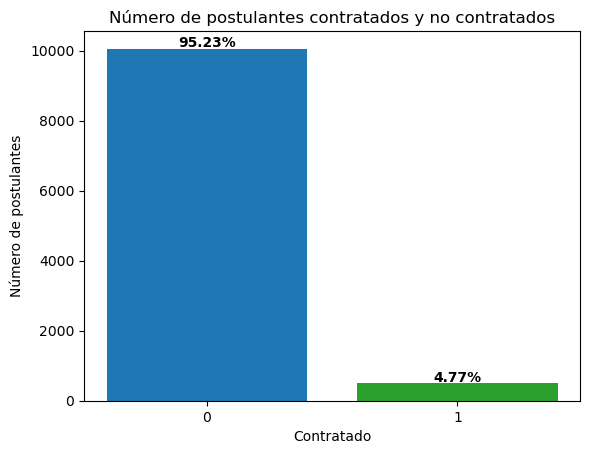

0    10058
1     2011
Name: contratado, dtype: int64


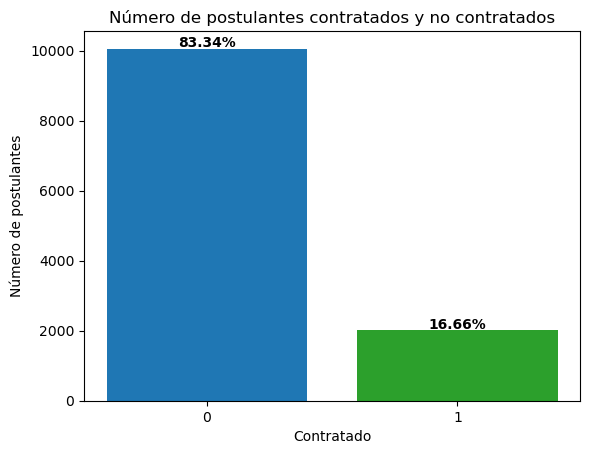

,column,differentValuesNumber
1,nombrePerfilConvocatoria,100
2,paisResidencia,14
3,empresaUltimoTrabajo,4227
4,paisUltimoTrabajo,31
5,areaUltimoTrabajo,152
6,nombreUltimoTrabajo,3153
7,institucionUltimoEstudio,1006
8,paisUltimoEstudio,30
9,areaUltimoEstudio,105
10,nombreUltimoEstudio,2478


,column,minValue,maxValue
1,sueldoPretendido,1.0,14600.0
2,diasUltimoTrabajo,5.0,2619.0
3,aniosExperiencia,0.1,32.9
4,numeroTrabajos,1.0,20.0
5,diasUltimoEstudio,1.0,6653.5
6,estadoUltimoEstudio,0.0,2.0
7,gradoUltimoEstudio,0.0,6.0
8,aniosEstudio,0.1,21.0
9,numeroEstudios,1.0,13.0
10,habilidadesTecnicas,1.0,35.0


11309
0.024077167145645704
1069
0.6577751679237217
963
Entrenando el modelo
Ejecutando para el algoritmo: K vecinos más cercanos
Ejecutando para el algoritmo: Máquina de vectores de soporte
Ejecutando para el algoritmo: Regresión logística
Ejecutando para el algoritmo: Naive bayes gaussiano
Ejecutando para el algoritmo: Aumento de gradiente
Ejecutando para el algoritmo: Árbol de decisión
Ejecutando para el algoritmo: Bosque aleatorio


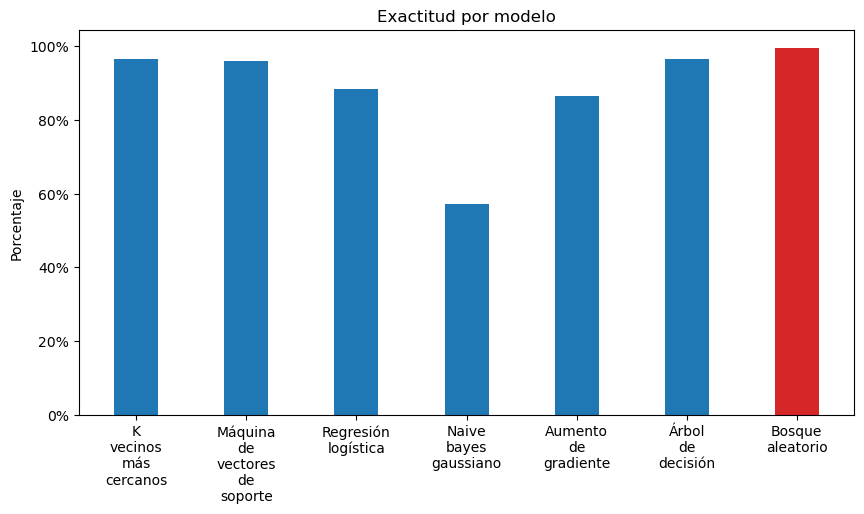

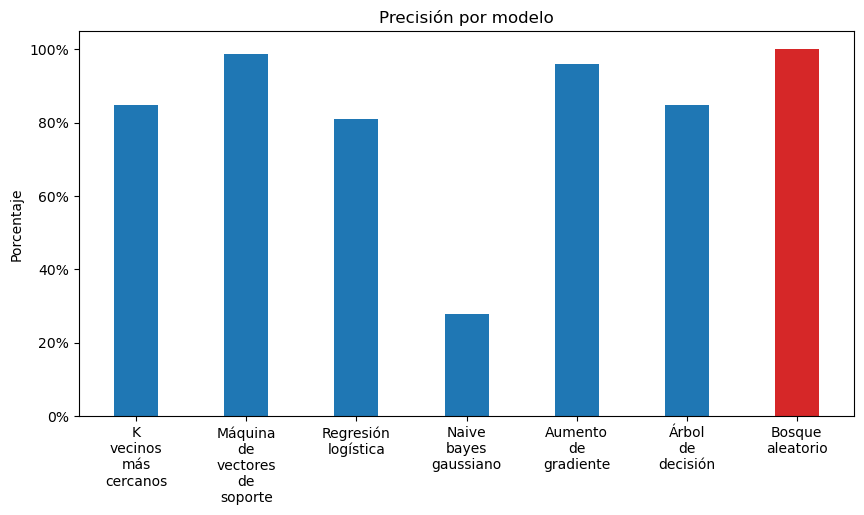

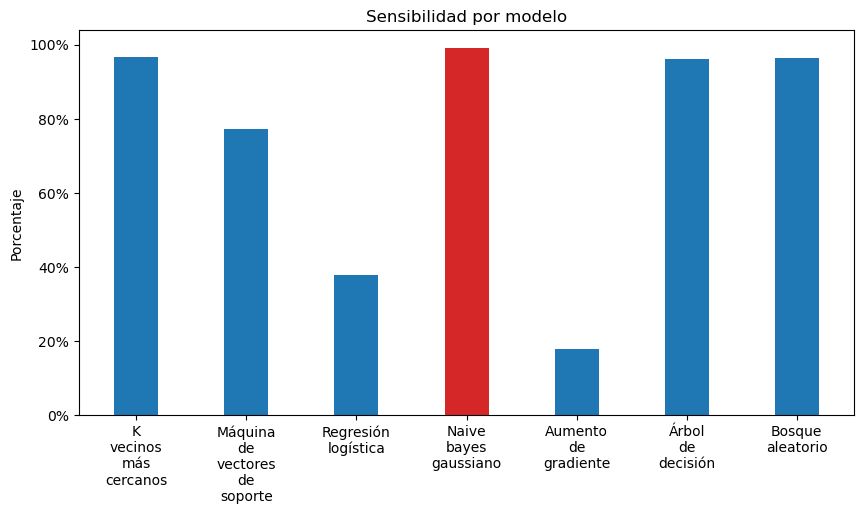

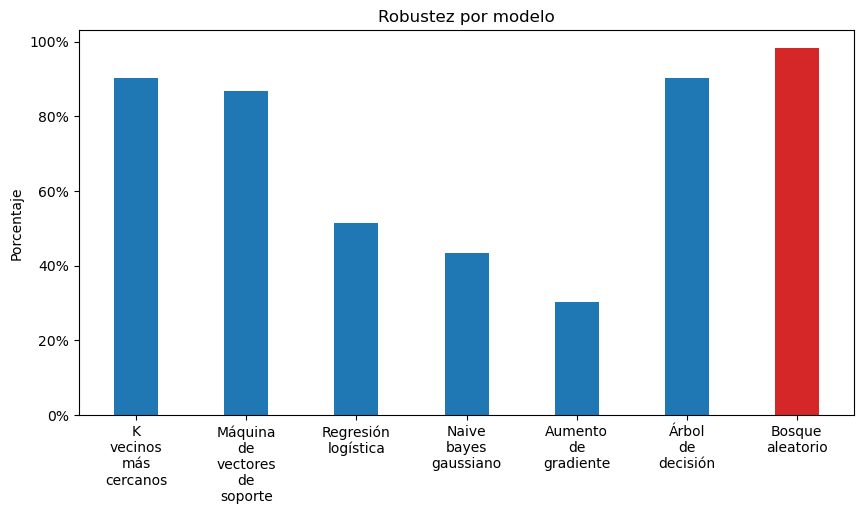

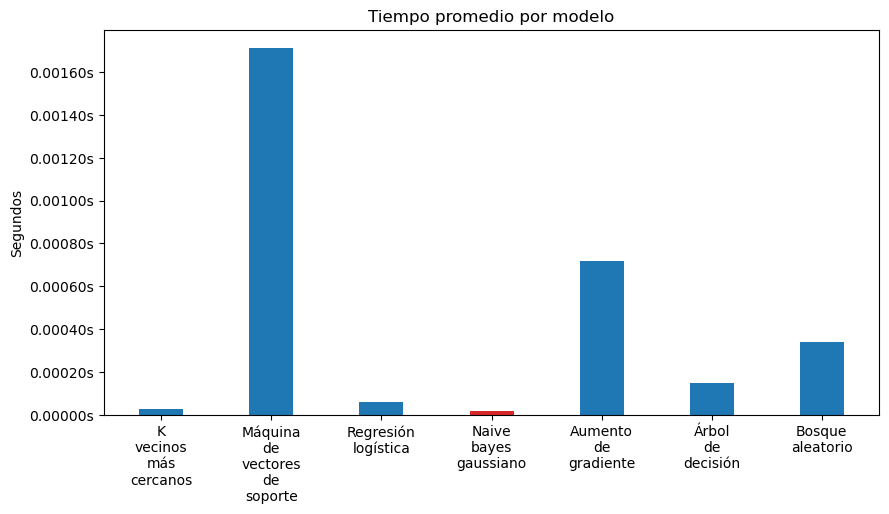

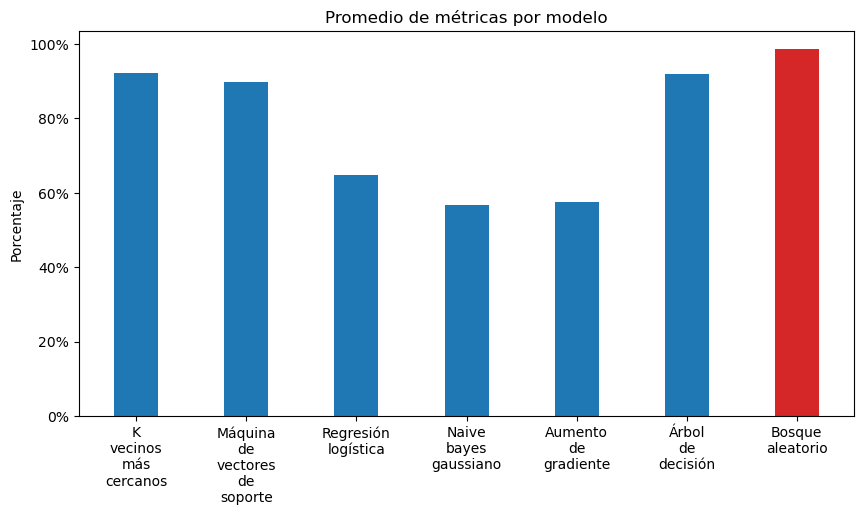


Algoritmo con mayor promedio de métricas: Bosque aleatorio
Promedio de métricas: 98.52%
Exactitud: 99.42%
Precisión: 100.00%
Sensibilidad: 96.47%
Robustez: 98.21%
Tiempo total: 4.14827s
Tiempo promedio: 0.00034s

Fin: 2023-06-14 22:21:00.178521
Tiempo: 0:01:04.026039


In [12]:
if __name__ == "__main__":
  main()